In [1]:
from scipy import stats
from statistics import mean, stdev
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
import sys
import os
if "../" not in sys.path:
  sys.path.append("../") 
import os
os.chdir("..") 
from envs.data_handler import DataHandler
import envs.data_utils as du

# Data Shift

* Step 1: Calculate the Standard Deviation
* Step 2: Create the ordering by the mean value for each <component,failure> group and sort them ascending by mean value, component name, failure name
* Step 3: Shift data

In [2]:
dh = DataHandler(data_generation='Linear', take_component_id=True, transformation='raw')
data_new = du.shift_data(dh.data)  
data_new.head()

,Optimal_Affected_Component_Uid,Optimal_Failure,raw
0,_SEwwu-cdEeet0YmmfbMwkw,CF1,138.2518
1,_SExXgOcdEeet0YmmfbMwkw,CF2,25.9559
2,_SEx_HucdEeet0YmmfbMwkw,CF3,61.6029
3,_SEymDucdEeet0YmmfbMwkw,CF3,50.0732
4,_SExYKucdEeet0YmmfbMwkw,CF3,25.9599


Perform T-Test:

In [3]:
ttest = du.execute_ttest(data_new)
num_distinguishable_pairs = len(ttest[ttest['pvalue']<0.05])
total = len(ttest.index) - 2
print('{0} of the {1} <component, failure> combination pairs are statistical significant'.format(num_distinguishable_pairs, total))

636 of the 912 <component, failure> combination pairs are statistical significant


# Parameterization

Evaluate different spread multiplication factors for an optimal shifting for each of the transformed datasets (e.g. cube/square root transfromation). We add to the series point of a <component,failure> group a shift value $s$, which is calculated as:

\begin{align}
s = f * (\sigma(x_{-1}) + \sigma(x)) + tieCount_{t}
\end{align}

Here, we evaluate different values for $f \in \mathbb{N}^{+}$ as the spread mulitplication factor which is mulitplied with the standard deviation of the previous <component,failure> combination $\sigma(x_{-1})$ and of the current one $\sigma(x)$. Since we shift the groups in the order of their ascending mean value, we add the $tieCount_{t}$ at for the comparison at time point $t$ which is the sum of the standard deviations of all <component,failure> pairs which have the same mean value.

In [4]:
def parameterize(start, end, step):

    result = {}

    trans = ['raw', 'cube', 'sqt', 'log10', 'ln', 'log2']
    factor = range(start, end, step)

    for t in trans:
        X = []
        Y = []

        # initialize the result dictionary for each transformation
        result[t] = (0,0) # (spread_multiplication_factor, number of statistical significant pairs) 

        # evaluate the different spread mulitplication factors
        for f in factor:

            # load the data 
            dh = DataHandler(data_generation='Linear', take_component_id=True, transformation=t)
            shifted_data = du.shift_data(dh.data, spread_multiplication_factor=f)
            ttest = du.execute_ttest(shifted_data)
            num_significant_pairs = len(ttest[ttest['pvalue']<0.05])

            # save the results for plotting
            X.append(f) # factor
            Y.append(num_significant_pairs) # number of statistical significant pairs

            if num_significant_pairs > result[t][1]:
                # we were able to generate at least one more statistical significant pair
                result[t] = (f, num_significant_pairs)

            print("{0}: With the spread multiplication factor of {1} we have {2} statistical significant pairs.    ".format(t, f, num_significant_pairs), end="\r")

        plt.plot(X, Y, label=t)


    print(result)
    plt.xlabel("Spread Multiplication Factor")
    plt.ylabel("No. of statistical significant pairs")
    plt.legend()
    plt.savefig('data_analysis/03_plots/shifting_parameter_evaluation_' + str(step) + '.pdf') 
    plt.show()

{'raw': (151, 667), 'cube': (241, 672), 'sqt': (231, 667), 'log10': (231, 672), 'ln': (231, 671), 'log2': (211, 666)}


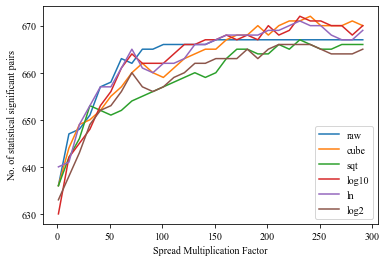

In [5]:
parameterize(1, 300, 10)

{'raw': (42, 658), 'cube': (49, 656), 'sqt': (29, 655), 'log10': (49, 658), 'ln': (45, 660), 'log2': (48, 655)}


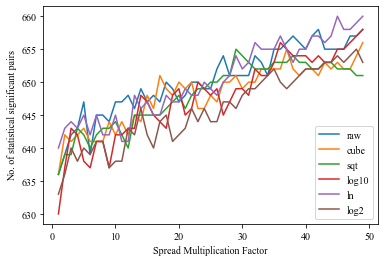

In [6]:
parameterize(1, 50, 1)

And then saving optimal shifted data to csv

In [7]:
result = {'raw': (151, 667), 'cube': (241, 672), 'sqt': (231, 667), 'log10': (231, 672), 'ln': (231, 671), 'log2': (211, 666)}
dh = DataHandler(data_generation='Linear', take_component_id=True, transformation='raw')
optimal_shifted_data = dh.data[[dh.data.columns[0], dh.data.columns[1]]]

for t, value in result.items():
    dh = DataHandler(data_generation='Linear', take_component_id=True, transformation=t)
    data = du.shift_data(dh.data, spread_multiplication_factor=value[0])
    ttest = du.execute_ttest(data)
    print("Shifting {0} data with a factor of {1} results in {2} distinguishable pairs.".format(t, value[0], len(ttest[ttest['pvalue']<0.05])))
    optimal_shifted_data = optimal_shifted_data.merge(data[[data.columns[2]]], how='outer', left_index=True, right_index=True)
    
optimal_shifted_data.to_csv('data/prepared_data/LinearShifted_Id.csv')
print("Data saved.")

Shifting raw data with a factor of 151 results in 667 distinguishable pairs.
Shifting cube data with a factor of 241 results in 672 distinguishable pairs.
Shifting sqt data with a factor of 231 results in 667 distinguishable pairs.
Shifting log10 data with a factor of 231 results in 672 distinguishable pairs.
Shifting ln data with a factor of 231 results in 671 distinguishable pairs.
Shifting log2 data with a factor of 211 results in 666 distinguishable pairs.
Data saved.


# Create datasets with only distinguishable <component,failue>

In [7]:
trans = ['raw', 'cube', 'sqt', 'log10', 'ln', 'log2']

for t in trans:
    dh = DataHandler(data_generation='LinearShifted', take_component_id=True, transformation=t)
    ttest = du.execute_ttest(dh.data)
    component_failure_list = du.get_distinguishable_groups(ttest)
    filtered_data = du.filter_dataset(dh.data, component_failure_list)
    ttest_2 = du.execute_ttest(filtered_data)
    num_significant_pairs = len(ttest_2[ttest_2['pvalue']<0.05])
    print("{0}: {1}/{2} statistical significant pairs   ".format(t, num_significant_pairs, len(ttest_2)))
    filtered_data.to_csv('data/prepared_data/LinearShifted_Id_' + t + '_dist.csv')
    
print("Data saved.")

raw: 728/730 statistical significant pairs   
cube: 727/737 statistical significant pairs   
sqt: 726/734 statistical significant pairs   
log10: 727/736 statistical significant pairs   
ln: 727/735 statistical significant pairs   
log2: 727/736 statistical significant pairs   
Data saved.
